# Forecasting Exercises
This exercise walks through a SARIMA prediction and forecast similar to the one done on the Mauna Loa CO₂ dataset.<br>
This time we're using a seasonal time series of California Hospitality Industry Employees.

<div class="alert alert-danger" style="margin: 10px"><strong>IMPORTANT NOTE!</strong> Make sure you don't run the cells directly above the example output shown, <br>otherwise you will end up writing over the example output!</div>

In [23]:
# RUN THIS CELL
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load datasets
df = pd.read_csv('Data/HospitalityEmployees.csv',index_col='Date',parse_dates=True)
df.index.freq = 'MS'
print(len(df))
print(df.head())

348
            Employees
Date                 
1990-01-01     1064.5
1990-02-01     1074.5
1990-03-01     1090.0
1990-04-01     1097.4
1990-05-01     1108.7


So <tt>df</tt> has 348 records and one column. The data represents the number of employees in thousands of persons as monthly averages from January, 1990 to December 2018.

### 1. Plot the source data
Create a line chart of the dataset. Optional: add a title and y-axis label.

<AxesSubplot:title={'center':'California Hospitality Industry Employees'}, xlabel='Date', ylabel='Thousands of Persons'>

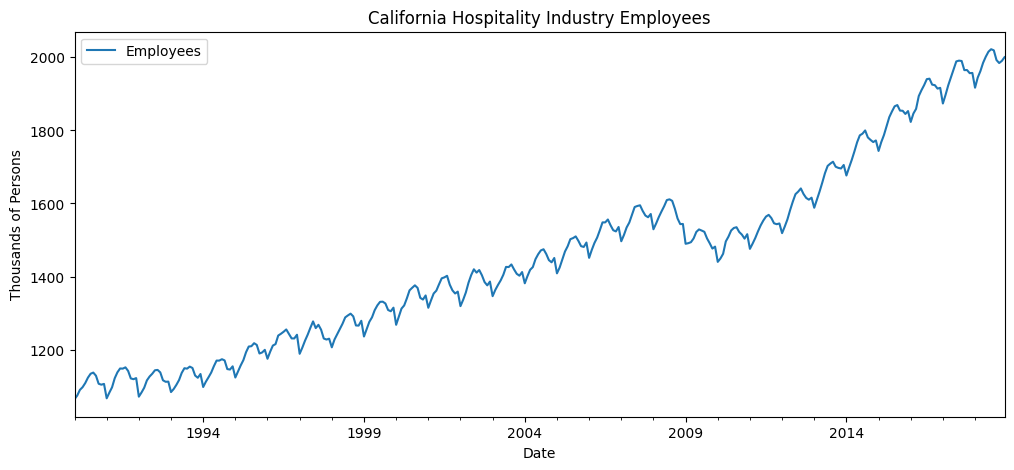

In [24]:
## CODE HERE
title = 'California Hospitality Industry Employees'
df.plot(figsize=(12,5),title=title,ylabel='Thousands of Persons')





### 2. Run an ETS Decomposition
Use an 'additive' model.

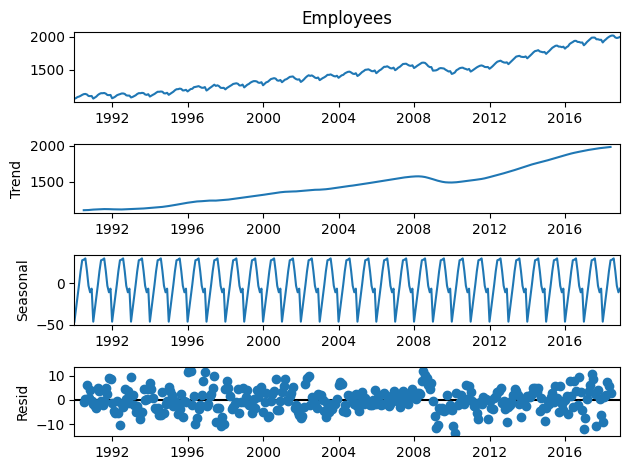

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['Employees'],
                            model='add')
result.plot();

### 3. Run <tt>pmdarima.auto_arima</tt> to obtain recommended orders
This may take awhile as there are a lot of combinations to evaluate.

In [26]:
df.head()

,Employees
Date,
1990-01-01,1064.5
1990-02-01,1074.5
1990-03-01,1090.0
1990-04-01,1097.4
1990-05-01,1108.7


In [27]:
auto_arima(df['Employees'],
           seasonal=True,
           m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  348
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood               -1098.252
Date:                              Sun, 12 Mar 2023   AIC                           2208.504
Time:                                      20:19:42   BIC                           2231.600
Sample:                                  01-01-1990   HQIC                          2217.700
                                       - 12-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9244      0.045     20.523      0.000       0.836       1.013
ma.L1         -0.9440      0.070    -13.544      0.000      -1.081      -0.807
ma.L2          0.1288      0.060      2.149      0.032       0.011       0.246
ar.S.L12       0.9972      0.001    702.308      0.000       0.994       1.000
ma.S.L12      -0.7490      0.043    -17.322      0.000      -0.834      -0.664
sigma2        29.2982      1.717     17.064      0.000      25.933      32.663
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                67.43
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -0.11
Prob(H) (two-sided):                  0.40   Kurtosis:                         5.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

You should see a recommended ARIMA Order of (0,1,0) combined with a seasonal order of (2,0,0,12).
### 4. Split the data into train/test sets
Set one year (12 records) for testing. There is more than one way to do this!

In [28]:
train = df[:len(df)-12]
test = df[len(df)-12:]

In [29]:
len(train)

336

In [30]:
len(test)

12

### 5. Fit a SARIMA(0,1,0)(2,0,0,12) model to the training set

In [31]:
model_sarima = SARIMAX(train['Employees'],
                       order=(1,1,2),
                       seasonal_order=(1,0,1,12))
results_sarima = model_sarima.fit()
results_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            Employees   No. Observations:                  336
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood               -1058.058
Date:                              Sun, 12 Mar 2023   AIC                           2128.116
Time:                                      20:19:43   BIC                           2151.001
Sample:                                  01-01-1990   HQIC                          2137.240
                                       - 12-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9241      0.043     21.248      0.000       0.839       1.009
ma.L1         -0.9584      0.070    -13.679      0.000      -1.096      -0.821
ma.L2          0.1498      0.061      2.466      0.014       0.031       0.269
ar.S.L12       0.9973      0.001    731.539      0.000       0.995       1.000
ma.S.L12      -0.7519      0.044    -17.161      0.000      -0.838      -0.666
sigma2        28.7642      1.684     17.081      0.000      25.464      32.065
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                73.33
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -0.17
Prob(H) (two-sided):                  0.63   Kurtosis:                         5.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 6. Obtain predicted values

In [32]:
predictions_sarima = results_sarima.predict(
    start=len(train),
    end = len(train) + len(test) -1,
    typ='levels',
).rename('SARIMA (1,1,2)(1,0,1,12) Predictions')

### 7. Plot predictions against known values
Optional: add a title and y-axis label.

[Text(0.5, 0, ''), Text(0, 0.5, 'Thousands of Persons')]

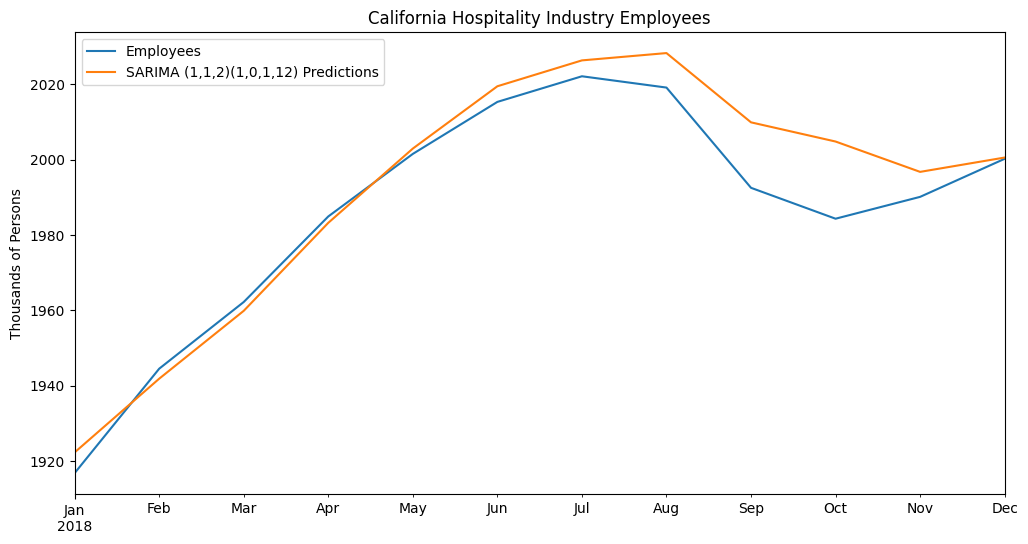

In [33]:
title='California Hospitality Industry Employees'
ylabel='Thousands of Persons'
xlabel=''

ax = test['Employees'].plot(title=title,
                       figsize=(12,6),
                       legend=True)
predictions_sarima.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel,
       ylabel=ylabel)


### 8. Evaluate the Model using MSE and RMSE
You can run both from the same cell if you want.

In [34]:
mse = mean_squared_error(test['Employees'],
                         predictions_sarima) 
mse

77.63883878851833

In [35]:
error_rmse = rmse(test['Employees'],
                         predictions_sarima)
error_rmse

8.811290415626893

### 9. Retrain the model on the full data and forecast one year into the future

In [36]:
sarima_model = SARIMAX(df['Employees'],
                       order=(1,1,2),
                       seasonal_order=(1,0,1,12))
sarima_results = sarima_model.fit()

fcast = sarima_results.predict(len(df),
                               len(df)+11,
                               typ='levels').rename('SARIMA(1,1,2)(1,0,1,12) Forecast')

### 10. Plot the forecasted values alongside the original data
Optional: add a title and y-axis label.

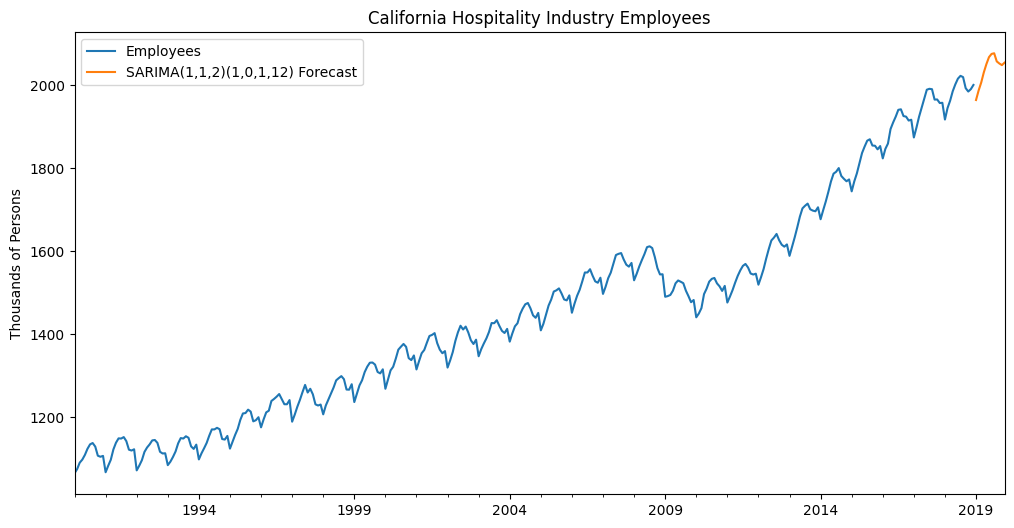

In [37]:
title='California Hospitality Industry Employees'
ylabel='Thousands of Persons'
xlabel=''

ax = df['Employees'].plot(legend=True,
                          figsize=(12,6),
                          title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',
             tight=True)
ax.set(xlabel=xlabel, 
       ylabel=ylabel);